In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
import copy
import os
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

from ms_stim_analysis.AnalysisTables.ms_dio_event import DioEvents, ProcessedDioEvents
from ms_stim_analysis.AnalysisTables.ms_task_identification import TaskIdentification
from ms_stim_analysis.AnalysisTables.ms_interval import EpochIntervalListName
from ms_stim_analysis.AnalysisTables.Utils.df_helpers import df_pop, df_from_data_list
from ms_stim_analysis.AnalysisTables.Utils.plot_helpers import format_ax
from ms_stim_analysis.AnalysisTables.Utils.stats_helpers import (
    average_confidence_interval,
)
from ms_stim_analysis.AnalysisTables.ms_task_performance import *
from ms_stim_analysis.Analysis.EM_fitting.AS_EM_module import EM_main
from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol
from ms_stim_analysis.Style.style_guide import animal_style

from pathlib import Path

[2025-08-26 09:04:45,272][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [11]:
# # Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection
# paper_key = {"paper_id":"ms_stim_analysis"}

# analysis_id = "learning_curves"
# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[09:07:55][INFO] Spyglass: Starting {'export_id': 31}


## Get performance outcomes across epochs on w track, for each animal and for each trial type

### Get animal data from prior publication 
(“Dynamic Synchronization between Hippocampal Representations and Stepping.
Joshi et. al 2023)

In [12]:
def get_file_contents(file_name, file_path=None):
    file_obj = open(file_name, "r")
    file_contents = file_obj.read()
    file_obj.close()

    return file_contents


# Convert task performance to binary
def get_binary_performance(outcomes):
    binary_performance_vals = []
    for x in outcomes:
        first_part = x.split("_")[0]
        if first_part == "incorrect":
            binary_performance_vals.append(0)
        elif first_part == "correct":
            binary_performance_vals.append(1)
    return binary_performance_vals

In [ ]:
# Initialize variable for storing data for df
data_list_non_ms = []

# Add data from non-MS cohort
cohort_type = "non_MS"

# Define non-MS animals
non_ms_subject_ids = ["Jaq", "Lotus", "Monty", "Roqui"]

for subject_id in non_ms_subject_ids:
    data_dir = Path(f"Data/{subject_id}_wtrack_statescripts")
    # Get file names
    file_names = os.listdir(data_dir)

    # Get percent correct, and number of trials
    performance_outcomes_map = dict()

    for file_name in file_names:

        # Get file contents
        file_contents = get_file_contents(data_dir / file_name)

        # Split by new line
        file_contents = file_contents.split("\n")

        # Drop comment lines
        file_contents_ = []
        for x in file_contents:
            if len(x) > 0:
                if x[0] != "#":
                    file_contents_.append(x)
        file_contents = file_contents_

        # Save only UP and DOWN lines
        file_contents = [
            x for x in file_contents if any([z in x for z in ["UP", "DOWN"]])
        ]

        # Drop initial number
        file_contents = [x.split(" ")[1:] for x in file_contents]

        # Get rid of repeat ups and downs at same well
        last_up, last_down = np.nan, np.nan
        ups, downs = [], []
        for x, y in file_contents:
            if x == "UP":
                current_up = int(y)
                if current_up != last_up:
                    ups.append(copy.deepcopy(current_up))
                    last_up = current_up
            elif x == "DOWN":
                current_down = int(y)
                if current_down != last_down:
                    downs.append(copy.deepcopy(current_down))
                    last_down = current_down

        if ups[: len(downs)] != downs:
            raise Exception("ups not same as downs; this is unexpected")

        # Replace numbers with well visit text
        replace_nums_map = {2: "home", 1: "outer_1", 3: "outer_2"}
        well_visits = [replace_nums_map[x] for x in ups]

        # Parse well visits into correct and incorrect
        previous_well = None
        previous_outer_well = None

        performance_outcomes = []
        for idx, current_well in enumerate(well_visits):

            # Check that current well not same as previous well
            if current_well == previous_well:
                raise Exception

            # Correct outbound
            if previous_well == "home" and np.logical_or(
                current_well == "outer_1" and previous_outer_well == "outer_2",
                current_well == "outer_2" and previous_outer_well == "outer_1",
            ):
                performance_outcomes.append("correct_outbound")

            # Correct inbound
            elif (
                previous_well == "outer_1" or previous_well == "outer_2"
            ) and current_well == "home":
                performance_outcomes.append("correct_inbound")

            # Incorrect outbound
            elif previous_well == "home" and np.logical_or(
                current_well == "outer_1" and previous_outer_well == "outer_1",
                current_well == "outer_2" and previous_outer_well == "outer_2",
            ):
                performance_outcomes.append("incorrect_outbound")

            # Incorrect inbound
            elif np.logical_or(
                current_well == "outer_1" and previous_well == "outer_2",
                current_well == "outer_2" and previous_well == "outer_1",
            ):
                performance_outcomes.append("incorrect_inbound")

            # First home
            elif current_well == "home" and previous_well is None:
                performance_outcomes.append("first_home")

            # First outer
            elif (
                current_well == "outer_1" or current_well == "outer_2"
            ) and previous_outer_well is None:
                performance_outcomes.append("first_outer")

            # Not assigned
            else:
                raise Exception

            # Set previous well to current well
            previous_well = current_well

            # Set previous outer well if indicated
            if current_well == "outer_1" or current_well == "outer_2":
                previous_outer_well = current_well

        # Store
        split_file_name = file_name.split("_")
        date = split_file_name[0]
        epoch = int(split_file_name[2])

        data_list_non_ms.append(
            (subject_id, date, epoch, cohort_type, performance_outcomes)
        )

### get ms animal data


In [14]:
# Get performance outcomes across epochs on w track, for each animal and for each trial type
# single day
nwb_file_names_map = {
    "Yoshi": [
        "Yoshi20220517_.nwb",
    ],  # "Yoshi20220518_.nwb",],
    "Olive": ["Olive20220711_.nwb"],
    "Wallie": ["Wallie20220922_.nwb"],
    "Bilbo": [
        "Bilbo20230802_.nwb",
    ],  # "Bilbo20230804_.nwb"],# no entrainment
    "Totoro": [
        "Totoro20220613_.nwb",
    ],  # "Totoro20220614_.nwb"],
    "Winnie": [
        "Winnie20220719_.nwb",
    ],  # "Winnie20220720_.nwb"],
    "Banner": [
        "Banner20220224_.nwb",
    ],  # "Banner20220225_.nwb"],
    "Frodo": [
        "Frodo20230814_.nwb",
    ],  # "Frodo20230815_.nwb","Frodo20230816_.nwb",]
}  # entrainment  #
# Multiple day
nwb_file_names_map = {
    "Yoshi": [
        "Yoshi20220517_.nwb",
        "Yoshi20220518_.nwb",
    ],
    "Olive": ["Olive20220711_.nwb"],
    "Wallie": ["Wallie20220922_.nwb"],
    "Bilbo": ["Bilbo20230802_.nwb", "Bilbo20230804_.nwb"],  # no entrainment
    "Totoro": ["Totoro20220613_.nwb", "Totoro20220614_.nwb"],
    "Winnie": [
        "Winnie20220719_.nwb",
    ],  # "Winnie20220720_.nwb"],
    "Banner": ["Banner20220224_.nwb", "Banner20220225_.nwb"],
    "Frodo": [
        "Frodo20230814_.nwb",
    ],  # "Frodo20230815_.nwb","Frodo20230816_.nwb",]
}

trial_types = ["all", "outbound", "inbound"]
optogenetic_types = ["control", "test", "all"]

data_list = []  # initialize list to store correct/incorrect outcomes
# For nwb file names

for optogenetics in optogenetic_types:
    for rat_name, nwb_file_names in nwb_file_names_map.items():
        # Loop through trial types
        for trial_type in trial_types:
            resp_values = []
            # Loop through epochs where contingency is wtrack
            total_trial_count = 0
            trial_number = []
            for nwb_file_name in nwb_file_names:
                key = {"nwb_file_name": nwb_file_name}
                # Get epochs where contingency is wtrack
                epochs = []
                for contingency in ["wtrack", "w-track"]:
                    epochs.extend(
                        (
                            TaskIdentification & {**key, **{"contingency": contingency}}
                        ).fetch("epoch")
                    )
                if rat_name == "Frodo_stim" and nwb_file_name == "Frodo20230815_.nwb":
                    epochs = [2, 4]
                if (
                    rat_name == "Frodo_no_stim"
                    and nwb_file_name == "Frodo20230815_.nwb"
                ):
                    epochs = np.array(epochs)
                    epochs = epochs[epochs > 5]
                print(key)
                print("Epochs:", epochs)

                for epoch in epochs:
                    key.update({"epoch": epoch})

                    # Get performance outcomes
                    table_intersection = AlternationTaskPerformance & key
                    if len(table_intersection) == 0:
                        print(f"no entry found in AlternationTaskPerformance for {key}")
                        continue
                    performance_outcomes = table_intersection.fetch1(
                        "performance_outcomes"
                    )
                    # SB: restrict by optogenetic period or control
                    if optogenetics in ["test", "control"]:
                        poke_event_times = (
                            ProcessedDioEvents.FirstUpPokes() & key
                        ).fetch1("dio_first_poke_times")
                        # get the control interval
                        if EpochIntervalListName() & key:
                            pos_interval_name = (EpochIntervalListName() & key).fetch1(
                                "interval_list_name"
                            )
                            dio_info_key = {
                                "nwb_file_name": nwb_file_name,
                                "interval_list_name": pos_interval_name,
                                "dio_event_name": "stim",
                            }
                            control_interval = OptoStimProtocol().get_control_intervals(
                                dio_info_key
                            )  # [0][0]
                            if len(control_interval) == 0:
                                print(
                                    "missing parameterized optogenetics: ", dio_info_key
                                )
                                continue
                            control_interval = control_interval[0][0]
                        else:
                            print(
                                f"No position tracking for {key}. Assuming no stimulus interval"
                            )
                            control_interval = [0, 1e20]

                        # label each event as in test or control
                        optogenetic_event = [
                            (
                                event_time < control_interval[0]
                                or event_time > control_interval[1]
                            )
                            for event_time in poke_event_times
                        ]
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            optogenetic_event = [
                                y
                                for (x, y) in zip(
                                    performance_outcomes, optogenetic_event
                                )
                                if trial_type in x
                            ]
                            performance_outcomes = [
                                x for x in performance_outcomes if trial_type in x
                            ]
                        epoch_trial_number = (
                            np.arange(len(performance_outcomes)) + total_trial_count
                        )
                        total_trial_count += len(epoch_trial_number)
                        # filter on condition
                        performance_outcomes = [
                            x
                            for (x, opto) in zip(
                                performance_outcomes, optogenetic_event
                            )
                            if (
                                (opto and optogenetics == "test")
                                or ((not opto) and optogenetics == "control")
                            )
                        ]
                        epoch_trial_number = [
                            x
                            for (x, opto) in zip(epoch_trial_number, optogenetic_event)
                            if (
                                (opto and optogenetics == "test")
                                or ((not opto) and optogenetics == "control")
                            )
                        ]

                    else:  # no optogenetic restriction
                        # Restrict to inbound or outbound if indicated
                        if trial_type in ["inbound", "outbound"]:
                            performance_outcomes = [
                                x for x in performance_outcomes if trial_type in x
                            ]
                        epoch_trial_number = (
                            np.arange(len(performance_outcomes)) + total_trial_count
                        )
                        total_trial_count += len(epoch_trial_number)

                    # Convert to binary
                    performance_outcomes = np.asarray(
                        performance_outcomes_to_int(performance_outcomes)
                    )

                    # Remove nans
                    resp_values.extend(
                        performance_outcomes[np.isfinite(performance_outcomes)]
                    )
                    trial_number.extend(
                        np.array(epoch_trial_number)[np.isfinite(performance_outcomes)]
                    )

            # Store result
            data_list.append(
                (rat_name, trial_type, resp_values, optogenetics, trial_number)
            )
# Convert results to df
res_values_df = df_from_data_list(
    data_list,
    ["rat_name", "trial_type", "resp_values", "optogenetic_type", "trial_number"],
)

{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220517_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Yoshi20220518_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Olive20220711_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Wallie20220922_.nwb'}
Epochs: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
{'nwb_file_name': 'Bilbo20230802_.nwb'}
Epochs: [

## Merge the two sets

In [ ]:
non_ms_df = df_from_data_list(
    data_list_non_ms,
    ["subject_id", "date", "epoch", "cohort_type", "performance_outcomes"],
)
non_ms_df_formatted = []
for subject in non_ms_df.subject_id.unique():
    base_entry = {"rat_name": subject, "optogenetic_type": "control"}

    subject_df = non_ms_df[non_ms_df.subject_id == subject]
    epoch_list = subject_df.epoch.values
    epoch_list.sort()
    outcomes = []
    for epoch in epoch_list:
        outcomes.extend(
            subject_df[subject_df.epoch == epoch].performance_outcomes.values[0]
        )
    outcomes = np.array([x for x in outcomes if not "first" in x])
    accuracy = np.array([int("incorrect" not in x) for x in outcomes])
    trial_type = np.array([x.split("_")[-1] for x in outcomes])

    all_trial_entry = {
        **base_entry,
        "trial_type": "all",
        "resp_values": accuracy,
        "trial_number": list(np.arange(len(accuracy))),
    }

    ind = trial_type == "outbound"
    outbound_entry = {
        **base_entry,
        "trial_type": "outbound",
        "resp_values": accuracy[ind],
        "trial_number": np.arange(ind.sum()),
    }
    ind = trial_type == "inbound"
    inbound_entry = {
        **base_entry,
        "trial_type": "inbound",
        "resp_values": accuracy[ind],
        "trial_number": np.arange(ind.sum()),
    }
    non_ms_df_formatted.extend([all_trial_entry, outbound_entry, inbound_entry])


df_2 = pd.DataFrame(non_ms_df_formatted)

res_values_df = pd.concat([res_values_df, df_2])

# Plot Learning curves

In [16]:
nwb_file_names_map = {
    "Yoshi": [
        "Yoshi20220517_.nwb",
        "Yoshi20220518_.nwb",
    ],
    "Olive": ["Olive20220711_.nwb"],
    "Wallie": ["Wallie20220922_.nwb"],
    "Bilbo": ["Bilbo20230802_.nwb", "Bilbo20230804_.nwb"],  # no entrainment
    "Totoro": ["Totoro20220613_.nwb", "Totoro20220614_.nwb"],
    "Winnie": ["Winnie20220719_.nwb", "Winnie20220720_.nwb"],
    "Banner": ["Banner20220224_.nwb", "Banner20220225_.nwb"],
    "Frodo": [
        "Frodo20230814_.nwb",
    ],  # "Frodo20230815_.nwb","Frodo20230816_.nwb",]
}

<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_125999/1452882426.py:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if optogenetics is "test":


sigma2e: 0.25
Converged after 278 iterations
sigma2e is  0.01912726075966516
sigma2e: 0.25
Converged after 408 iterations
sigma2e is  0.011235810878323291
sigma2e: 0.25
Converged after 465 iterations
sigma2e is  0.010599751711413676
sigma2e: 0.25
Converged after 270 iterations
sigma2e is  0.017018839646159394
sigma2e: 0.25
Converged after 268 iterations
sigma2e is  0.008176948162697081
sigma2e: 0.25
Converged after 360 iterations
sigma2e is  0.006397938383708034
sigma2e: 0.25
Converged after 205 iterations
sigma2e is  0.12622736631575568
sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.13977807871021214
sigma2e: 0.25
Converged after 344 iterations
sigma2e is  0.08763365778638663
sigma2e: 0.25
Converged after 227 iterations
sigma2e is  0.09915476868597614
sigma2e: 0.25
Converged after 296 iterations
sigma2e is  0.013225785358475746
sigma2e: 0.25
Converged after 320 iterations
sigma2e is  0.010114707003689272
sigma2e: 0.25
Converged after 92 iterations
sigma2e is  0.24480177760

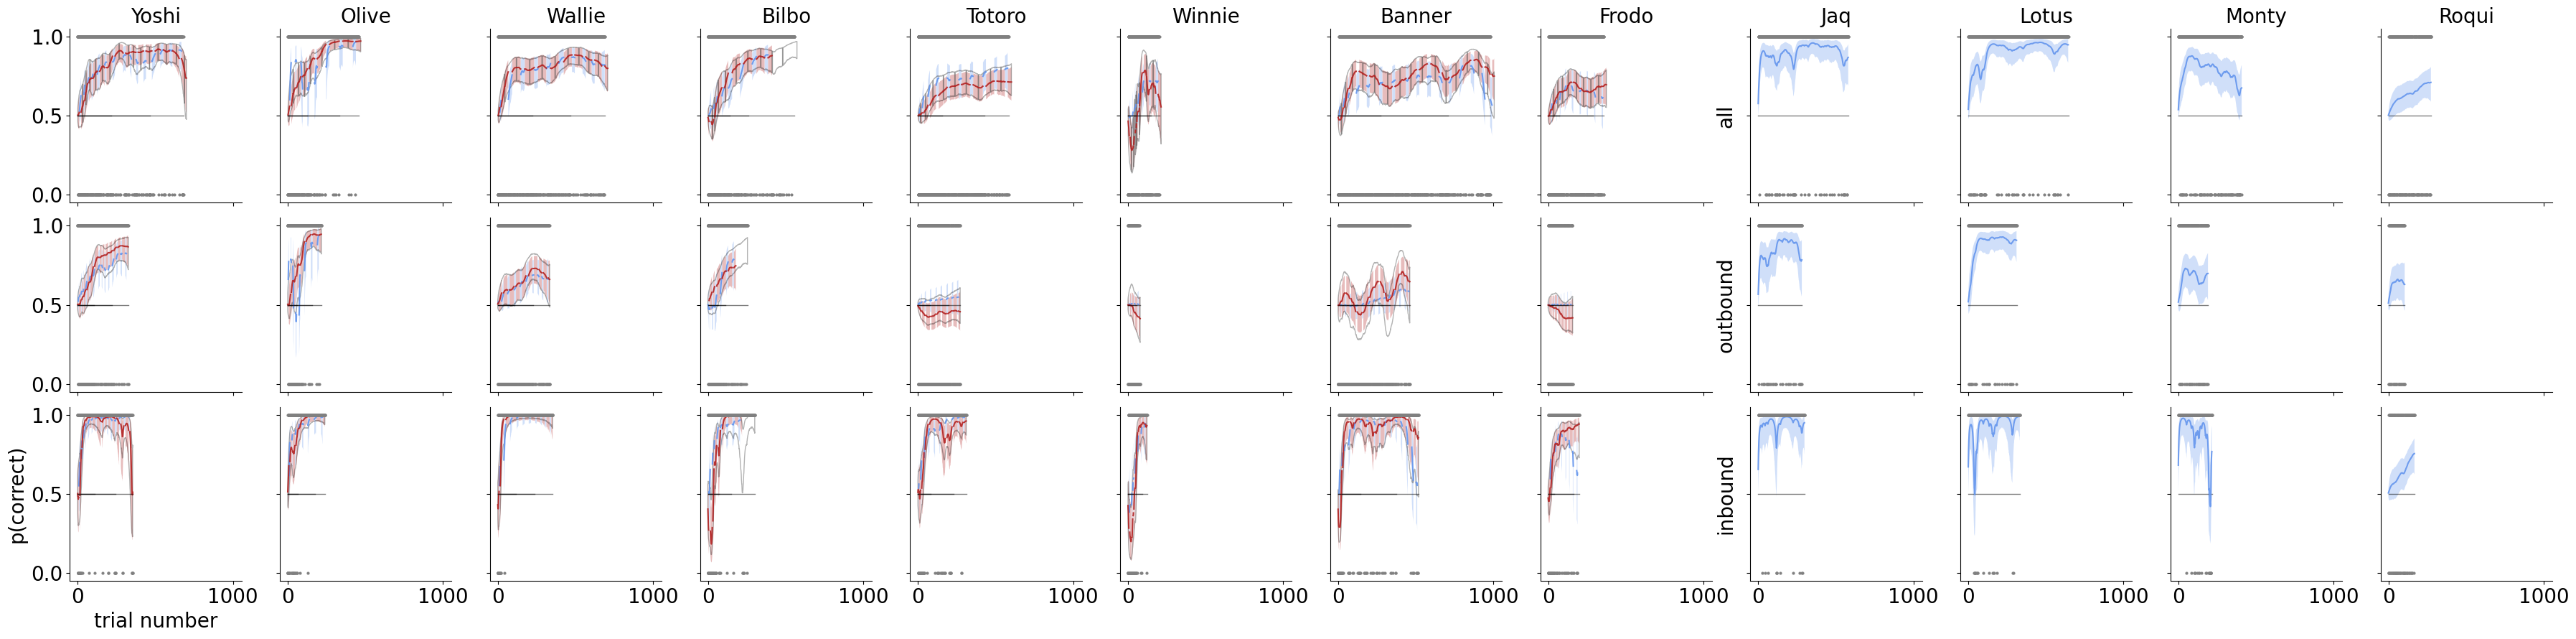

In [18]:
from ms_stim_analysis.Analysis.EM_fitting.AS_EM_module import EM_main, RunEM

trial_types = ["all", "outbound", "inbound"]
optogenetic_types = ["control", "test", "all"]

# Plot parameters
p_init = 0.5
subplot_width = 3
subplot_height = 3

plot_animals = res_values_df.rat_name.unique()
# Initialize figure
num_columns = max(len(plot_animals), 2)
num_rows = len(trial_types)
fig, axes = plt.subplots(
    num_rows,
    num_columns,
    figsize=(subplot_width * num_columns, subplot_height * num_rows),
    sharex=True,
    sharey=True,
)
# Plot learning curves
data_list = []
# plot_animals = list(nwb_file_names_map.keys())


for rat_name_idx, rat_name in enumerate(plot_animals):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for optogenetics, color in zip(
            optogenetic_types, ["cornflowerblue", "firebrick", "none"]
        ):
            if not len(
                res_values_df[
                    np.logical_and(
                        res_values_df.rat_name == rat_name,
                        res_values_df.optogenetic_type == optogenetics,
                    )
                ]
            ):
                continue

            resp_values = df_pop(
                res_values_df,
                {
                    "rat_name": rat_name,
                    "trial_type": trial_type,
                    "optogenetic_type": optogenetics,
                },
                "resp_values",
            )
            trial_number = df_pop(
                res_values_df,
                {
                    "rat_name": rat_name,
                    "trial_type": trial_type,
                    "optogenetic_type": optogenetics,
                },
                "trial_number",
            )
            if len(resp_values) == 0:
                continue
            fig_ax_list = [fig, axes[trial_type_idx, rat_name_idx]]
            opto_label = "control"
            if optogenetics is "test":
                opto_label = "septal-transfected"
            fig, ax, pll, pul, pmode = EM_main(
                resp_values,
                p_init,
                fig_ax_list,
                color=color,
                label=optogenetics,
                trial_number=trial_number,
            )
            # Store lower limit
            data_list.append(
                (rat_name, trial_type, pll, optogenetics, trial_number, pmode)
            )
            title = ""
            ylabel = ""
            xlabel = ""
            if trial_type_idx == 0:
                title = rat_name
            if trial_type_idx == len(trial_types) - 1 and rat_name_idx == 0:
                ylabel = "p(correct)"
                xlabel = "trial number"
            if rat_name_idx == len(nwb_file_names_map) - 1:
                ylabel = trial_type
                ax.yaxis.set_label_position("right")
        format_ax(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
        fig.tight_layout()


# Add text to indicate learning trial
def get_first_entry_else_nan(x):
    if len(x) == 0:
        return np.nan
    return x[0]


pll_df = df_from_data_list(
    data_list,
    ["rat_name", "trial_type", "pll", "optogenetic_type", "trial_number", "pmode"],
)
learning_trials = [
    get_first_entry_else_nan(np.where(pll > 0.5)[0]) for pll in pll_df.pll
]


def indxVal_else_nan(values, indx):
    if indx is np.nan:
        return np.nan
    return values[indx]


learning_trials = [
    indxVal_else_nan(trial_number, ind)
    for (trial_number, ind) in zip(pll_df.trial_number, learning_trials)
]
pll_df["learning_trial"] = learning_trials

# for rat_name_idx, rat_name in enumerate(nwb_file_names_map.keys()):
#     for trial_type_idx, trial_type in enumerate(trial_types):
#         for loc,(optogenetics,color) in enumerate(zip(optogenetic_types,['cornflowerblue','firebrick'])):
#             resp_values = df_pop(res_values_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "resp_values")
#             if len(resp_values) == 0:
#                 continue
#             learning_trial = df_pop(pll_df, {"rat_name": rat_name, "trial_type": trial_type,'optogenetic_type':optogenetics}, "learning_trial")
#             ax = axes[trial_type_idx, rat_name_idx]
#             ax.text(0, .25+.1*loc, learning_trial, fontsize=20,color=color)
# axes[0,0].legend(loc='lower right',title='optogenetics')

In [19]:
plt.rcParams["svg.fonttype"] = "none"

fig.savefig("../Figures/individual_learning_curves.png")

## Learning Trial comparison (within animal)

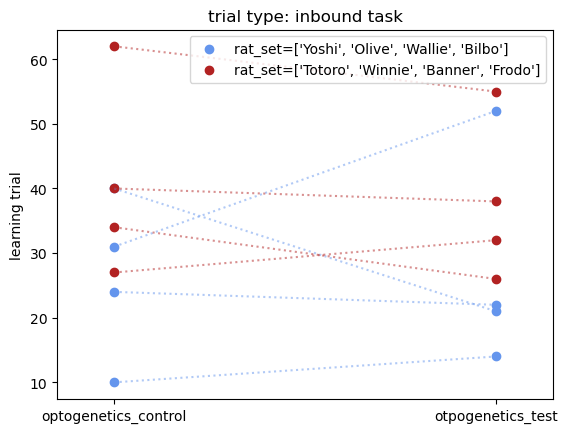

In [20]:
trial_type = "inbound"
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
set_nan = 340
df_ = pll_df[(pll_df["trial_type"] == trial_type)].copy()

included_nan = False
for rat_set, color in zip([control_rats, opto_rats], ["cornflowerblue", "firebrick"]):
    label = f"{rat_set=}"
    for rat_name in rat_set:
        lt_test = df_[
            (df_["optogenetic_type"] == "test") & (df_["rat_name"] == rat_name)
        ]["learning_trial"]
        lt_control = df_[
            (df_["optogenetic_type"] == "control") & (df_["rat_name"] == rat_name)
        ]["learning_trial"]
        if any(np.isnan([lt_test, lt_control])):  # or np.isnan(lt_control):
            included_nan = True
        lt_test = np.nan_to_num(lt_test, nan=set_nan)
        lt_control = np.nan_to_num(lt_control, nan=set_nan)
        plt.scatter(
            [0, 1],
            [
                lt_control,
                lt_test,
            ],
            color=color,
            label=label,
        )
        plt.plot(
            [0, 1],
            [
                lt_control,
                lt_test,
            ],
            color=color,
            ls=":",
            alpha=0.5,
        )
        label = None

plt.legend()
plt.xticks([0, 1], labels=["optogenetics_control", "otpogenetics_test"])
plt.ylabel("learning trial")
plt.title(f"trial type: {trial_type} task")
plt.xlim(-0.15, 1.15)
if included_nan:
    plt.fill_between(
        [-1, 2],
        [set_nan - 10, set_nan - 10],
        [set_nan - 50, set_nan - 50],
        facecolor="grey",
        alpha=0.3,
    )
    yticks = np.append(np.arange(0, 251, 50), [set_nan])
    yticks_labels = list(yticks.copy())
    yticks_labels[-1] = "not learned"

    plt.yticks(yticks, labels=yticks_labels)

## Learning Trial comparison between animals

Yoshi 22.0 64.0 43.0
Olive 8.0 26.0 14.0
Wallie 20.0 40.0 22.0
Bilbo 41.0 66.0 61.0
Jaq 0.0 2.0 0.0
Lotus 0.0 17.0 6.0
Monty 0.0 18.0 3.0
Roqui 66.0 17.0 41.0
Totoro 36.0 340.0 63.0
Winnie 54.0 345.0 81.0
Banner 28.0 222.0 47.0
Frodo 23.0 355.0 39.0


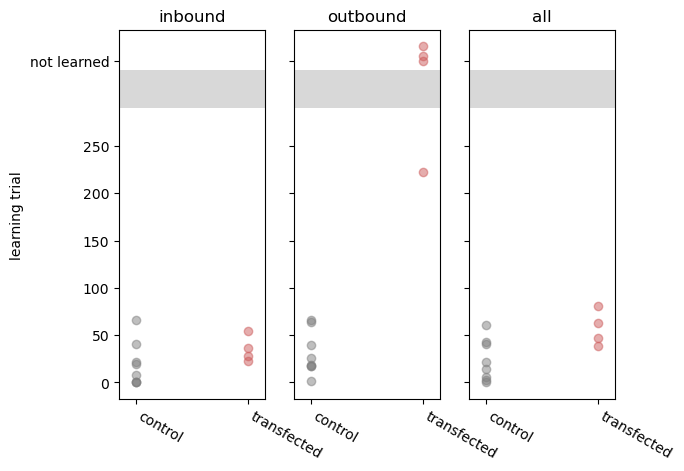

In [32]:
seperate_non_ms = False  # True
trial_type = "inbound"
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
# non_ms_rats =
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]

set_nan = 340
df_ = pll_df  # [(pll_df['trial_type']==trial_type)].copy()

trial_type = "all"  # optogenetic trial type
fig, ax = plt.subplots(ncols=3, sharey=True)
included_nan = False
rat_sets = [control_rats, opto_rats]
set_colors = [
    animal_style.loc[control_rats[0], "background"],
    animal_style.loc[opto_rats[0], "background"],
]
if seperate_non_ms:
    rat_sets = [non_ms_rats] + rat_sets
    set_colors = ["grey"] + set_colors

for i, (rat_set, color) in enumerate(zip(rat_sets, set_colors)):
    label = f"{rat_set=}"
    for ii, (rat_name) in enumerate(rat_set):
        if rat_name in non_ms_rats and trial_type == "all":
            trial_type_i = "control"
        else:
            trial_type_i = trial_type

        lt_in = df_[
            (df_["optogenetic_type"] == trial_type_i)
            & (df_["rat_name"] == rat_name)
            & (df_.trial_type == "inbound")
        ]["learning_trial"].values[0]
        lt_out = df_[
            (df_["optogenetic_type"] == trial_type_i)
            & (df_["rat_name"] == rat_name)
            & (df_.trial_type == "outbound")
        ]["learning_trial"].values[0]
        lt_all = df_[
            (df_["optogenetic_type"] == trial_type_i)
            & (df_["rat_name"] == rat_name)
            & (df_.trial_type == trial_type)
        ]["learning_trial"].values[0]
        if any(np.isnan([lt_in, lt_out])):  # or np.isnan(lt_control):
            included_nan = True
        lt_out = np.nan_to_num(lt_out, nan=set_nan + ii * 5)
        lt_in = np.nan_to_num(lt_in, nan=set_nan + ii * 5)
        ax[0].scatter([i], [lt_in], color=color, label=label, alpha=0.5)
        ax[1].scatter([i], [lt_out], color=color, label=label, alpha=0.5)
        ax[2].scatter([i], [lt_all], color=color, label=label, alpha=0.5)
        label = None
        print(rat_name, lt_in, lt_out, lt_all)
if included_nan:
    for a in ax:
        a.fill_between(
            [-1, 3],
            [set_nan - 10, set_nan - 10],
            [set_nan - 50, set_nan - 50],
            facecolor="grey",
            alpha=0.3,
        )
        yticks = np.append(np.arange(0, 251, 50), [set_nan])
        yticks_labels = list(yticks.copy())
        yticks_labels[-1] = "not learned"
        a.set_yticks(yticks, labels=yticks_labels)
        a.set_xlim(-0.15, len(rat_sets) - 0.85)
set_labels = ["control", "transfected"]
if seperate_non_ms:
    set_labels = ["non_ms"] + set_labels
for a in ax:
    a.set_xticks(np.arange(len(set_labels)))
    a.set_xticklabels(labels=set_labels, rotation=-30, ha="left")
ax[0].set_title("inbound")
ax[1].set_title("outbound")
ax[2].set_title("all")
ax[0].set_ylabel("learning trial")

separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_3bd_learning_trial.svg")

# Correct Fraction First n trials

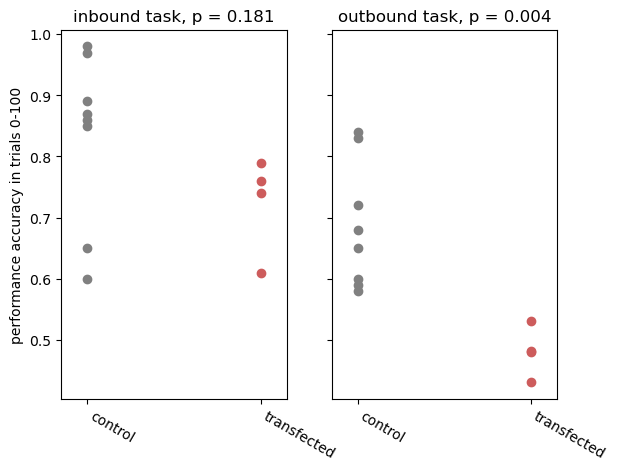

In [34]:
seperate_non_ms = False
trial_type = "inbound"
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
trial_sample = (0, 100)
optogenetic_type = "all"

fig, ax = plt.subplots(ncols=2, sharey=True)

from scipy.stats import ttest_ind

rat_sets = [control_rats, opto_rats]
set_colors = [
    animal_style.loc[control_rats[0], "background"],
    animal_style.loc[opto_rats[0], "background"],
]
if seperate_non_ms:
    rat_sets = [non_ms_rats] + rat_sets
    set_colors = ["grey"] + set_colors


for j, trial_type in enumerate(["inbound", "outbound"]):
    results = []
    df_ = res_values_df[(res_values_df["trial_type"] == trial_type)].copy()
    for i, (rat_set, color) in enumerate(zip(rat_sets, set_colors)):
        results.append([])
        for rat_name in rat_set:
            if rat_name in non_ms_rats and optogenetic_type == "all":
                optogenetic_type_i = "control"
            else:
                optogenetic_type_i = optogenetic_type
            lt_test = np.mean(
                np.asarray(
                    df_[
                        (df_["optogenetic_type"] == optogenetic_type_i)
                        & (df_["rat_name"] == rat_name)
                    ]["resp_values"]
                )[0][trial_sample[0] : trial_sample[1]]
            )
            results[-1].append(lt_test)
        ax[j].scatter(np.ones_like(results[-1]) * i, results[-1], color=color)
    np.round(ttest_ind(*results)[1], 3)
    ax[j].set_title(f"{trial_type} task, p = {np.round(ttest_ind(*results)[1],3)}")

# plt.legend()
set_labels = ["control", "transfected"]
if seperate_non_ms:
    set_labels = ["non_ms"] + set_labels
for a in ax:
    a.set_xticks(np.arange(len(set_labels)))
    a.set_xticklabels(labels=set_labels, rotation=-30, ha="left")
    a.set_xlim(-0.15, len(rat_sets) - 0.85)

ax[0].set_ylabel(f"performance accuracy in trials {trial_sample[0]}-{trial_sample[1]}")
separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_3bd_performance_accuracy.svg")

### Learning curve slope

/tmp/ipykernel_125999/3254085063.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(-0.15, 2.15)

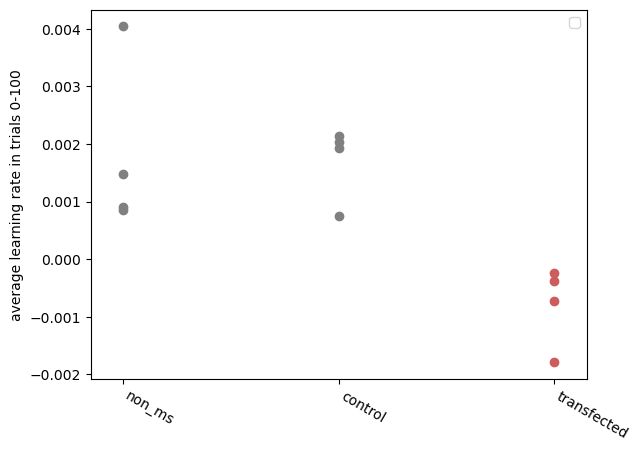

In [35]:
from scipy.stats import linregress

seperate_non_ms = True
trial_type = "outbound"
optogenetic_type = "all"

control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
trial_sample = (0, 100)

df_ = pll_df[(pll_df["trial_type"] == trial_type)].copy()

fig = plt.figure()
ax = fig.gca()
results = []
rat_sets = [control_rats, opto_rats]
set_colors = [
    animal_style.loc[control_rats[0], "background"],
    animal_style.loc[opto_rats[0], "background"],
]
if seperate_non_ms:
    rat_sets = [non_ms_rats] + rat_sets
    set_colors = ["grey"] + set_colors
for i, (rat_set, color) in enumerate(zip(rat_sets, set_colors)):
    results.append([])
    for rat_name in rat_set:
        if rat_name in non_ms_rats and optogenetic_type == "all":
            optogenetic_type_i = "control"
        else:
            optogenetic_type_i = optogenetic_type

        pmode = np.asarray(
            df_[
                (df_["optogenetic_type"] == optogenetic_type_i)
                & (df_["rat_name"] == rat_name)
            ]["pmode"]
        )[0][trial_sample[0] : trial_sample[1]]
        trial_number = np.asarray(
            df_[
                (df_["optogenetic_type"] == optogenetic_type_i)
                & (df_["rat_name"] == rat_name)
            ]["trial_number"]
        )[0][trial_sample[0] : trial_sample[1]]
        slope = linregress(trial_number, pmode)[0]
        results[-1].append(slope)
    plt.scatter(np.ones_like(results[-1]) * i, results[-1], color=color)

plt.legend()
set_labels = ["control", "transfected"]
if seperate_non_ms:
    set_labels = ["non_ms"] + set_labels
ax.set_xticks(np.arange(len(set_labels)))
ax.set_xticklabels(labels=set_labels, rotation=-30, ha="left")
plt.ylabel(f"average learning rate in trials {trial_sample[0]}-{trial_sample[1]}")
plt.xlim(-0.15, len(rat_sets) - 0.85)

# merged EM learning curves

<>:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_125999/111737943.py:93: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if optogenetics is "test":


sigma2e: 0.25
Converged after 374 iterations
sigma2e is  0.0024460553324560214
sigma2e: 0.25
Converged after 343 iterations
sigma2e is  0.0021139743111772036


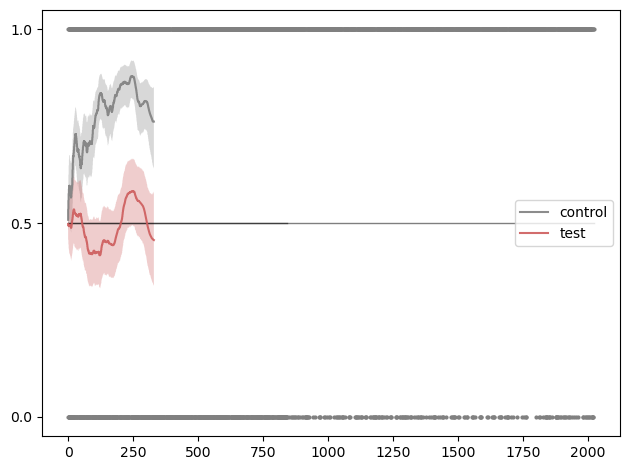

In [41]:
from ms_stim_analysis.Style.style_guide import transfection_style

seperate_non_ms = False
trial_type = "outbound"
control_rats = ["Yoshi", "Olive", "Wallie", "Bilbo"]
opto_rats = ["Totoro", "Winnie", "Banner", "Frodo"]
non_ms_rats = ["Jaq", "Lotus", "Monty", "Roqui"]
if not seperate_non_ms:
    control_rats.extend(non_ms_rats)
    rat_sets = {"control": control_rats, "test": opto_rats}
else:
    rat_sets = {"control": control_rats, "test": opto_rats, "non_ms": non_ms_rats}

trial_sample = (0, 100)
optogenetic_types = ["control"]
max_trials = 330
fig = plt.figure()
ax = fig.gca()

optogenetic_types = ["all"]
trial_types = [
    # "inbound",
    "outbound"
]


# Plot parameters
p_init = 0.5
subplot_width = 3
subplot_height = 3

plot_animals = rat_sets.keys()
# Initialize figure
num_columns = max(len(plot_animals), 2)
num_rows = len(trial_types)
# fig, axes = plt.subplots(num_rows, num_columns, figsize=(subplot_width*num_columns, subplot_height*num_rows), sharex=True, sharey=True)

# Plot learning curves
data_list = []
# plot_animals = list(nwb_file_names_map.keys())
colors = [transfection_style["control"], transfection_style["transfected"], "slateblue"]

for rat_name_idx, set_name in enumerate(rat_sets):
    for trial_type_idx, trial_type in enumerate(trial_types):
        for optogenetics, color in zip(
            optogenetic_types, ["cornflowerblue", "firebrick", "none"]
        ):
            # if not len(res_values_df[np.logical_and(res_values_df.rat_name==rat_name,
            #                          res_values_df.optogenetic_type==optogenetics)]):
            #     continue
            color = colors[rat_name_idx]
            resp_values = []
            trial_number = []
            for rat_name in rat_sets[set_name]:
                if rat_name in non_ms_rats and optogenetics == "all":
                    optogenetic_type_i = "control"
                else:
                    optogenetic_type_i = optogenetics
                resp_values.extend(
                    df_pop(
                        res_values_df,
                        {
                            "rat_name": rat_name,
                            "trial_type": trial_type,
                            "optogenetic_type": optogenetic_type_i,
                        },
                        "resp_values",
                    )
                )
                trial_number.extend(
                    df_pop(
                        res_values_df,
                        {
                            "rat_name": rat_name,
                            "trial_type": trial_type,
                            "optogenetic_type": optogenetic_type_i,
                        },
                        "trial_number",
                    )
                )
            ind = np.argsort(trial_number)  # [:50]
            trial_number = np.array(trial_number)[ind]
            resp_values = np.array(resp_values)[ind]
            ind = trial_number <= max_trials
            trial_number = np.array(trial_number)[ind]
            resp_values = np.array(resp_values)[ind]

            if len(resp_values) == 0:
                continue
            # fig_ax_list = [fig, axes[trial_type_idx, rat_name_idx]]
            fig_ax_list = [fig, ax]
            opto_label = "control"
            if optogenetics is "test":
                opto_label = "septal-transfected"
            fig, ax, pll, pul, pmode = EM_main(
                resp_values,
                p_init,
                fig_ax_list,
                color=color,
                label=set_name,
                trial_number=trial_number,
            )
            # Store lower limit
            data_list.append(
                (rat_name, trial_type, pll, optogenetics, trial_number, pmode)
            )
            title = ""
            ylabel = ""
            xlabel = ""
            if trial_type_idx == 0:
                title = rat_name
            if trial_type_idx == len(trial_types) - 1 and rat_name_idx == 0:
                ylabel = "p(correct)"
                xlabel = "trial number"
            if rat_name_idx == len(nwb_file_names_map) - 1:
                ylabel = trial_type
                ax.yaxis.set_label_position("right")
        # format_ax(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
        fig.tight_layout()
    # break


# Add text to indicate learning trial
def get_first_entry_else_nan(x):
    if len(x) == 0:
        return np.nan
    return x[0]


pll_df_merged = df_from_data_list(
    data_list,
    ["rat_name", "trial_type", "pll", "optogenetic_type", "trial_number", "pmode"],
)
learning_trials = [
    get_first_entry_else_nan(np.where(pll > 0.5)[0]) for pll in pll_df_merged.pll
]


def indxVal_else_nan(values, indx):
    if indx is np.nan:
        return np.nan
    return values[indx]


learning_trials = [
    indxVal_else_nan(trial_number, ind)
    for (trial_number, ind) in zip(pll_df_merged.trial_number, learning_trials)
]
pll_df_merged["learning_trial"] = learning_trials
ax.legend()

In [42]:
ax.set_xlim(0, 300)
ax.set_xlabel("trial number")
ax.set_ylabel("p(correct)")
separated_tag = "_non_ms_separated" if seperate_non_ms else ""
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("../Figures/Fig_3/Figure_3c_inbound_learning_curve.svg")
fig.savefig("../Figures/Fig_3/Figure_3c_outbound_learning_curve.svg")